In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.utils as utils

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
torch.manual_seed(77)

In [3]:
def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()


def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()



In [4]:
standardizer = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [5]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
noise_dim = 100
BATHC_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 200
N_CRITIC = 5
W_CLIP = 0.01

In [7]:
train_data = datasets.MNIST(root='../mnist/', train=True, download=True, transform=standardizer)
test_data = datasets.MNIST(root='../mnist/', train=False, download=True, transform=standardizer)
total_train = torch.utils.data.ConcatDataset([train_data, test_data])

train_dataloader = torch.utils.data.DataLoader(dataset=total_train, batch_size=BATHC_SIZE, shuffle=True)

In [8]:
# DCGAN과 완전 동일한 generator와 discriminator를 사용한다

class wCritic(nn.Module):
    def __init__(self):
        super(wCritic, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
    def forward(self, x):
        x = self.model(x)
        x = x.view((-1, 1))
        return x

In [9]:
class wGen(nn.Module):
    def __init__(self):
        super(wGen, self).__init__()
        self.dconv = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view((-1, noise_dim, 1, 1))
        x = self.dconv(x)
        return x

In [10]:
def get_z(batch_size=BATHC_SIZE):
    return cuda.FloatTensor(torch.randn(batch_size, noise_dim, device=device))

In [11]:
def train(G, D, optim_G, optim_D, train_loader):
    G.train()
    D.train()
    for epoch in tqdm(range(EPOCHS)):
        for imgs, _ in train_loader:
            imgs = imgs.to(device)
            for it in range(N_CRITIC):
                optim_D.zero_grad()

                z = get_z()

                fake_imgs = G(z)

                loss_d = torch.mean(D(fake_imgs)) - torch.mean(D(imgs))

                loss_d.backward()
                optim_D.step()

                with torch.no_grad():
                    for param in D.parameters():
                        param.clamp_(-W_CLIP, W_CLIP)
                D.train()

            optim_G.zero_grad()

            gen_imgs = G(get_z())

            loss_g = -torch.mean(D(gen_imgs))

            loss_g.backward()

            optim_G.step()
            
        if epoch % 10 == 0:
            print(f'[{epoch}/{EPOCHS}] loss_d : {loss_d:.4f}, loss_g : {loss_g:.4f}')
            imshow_grid(G(get_z(batch_size=16)))

    torch.save(G, './model/wGenerator.pth')
    torch.save(D, './model/wDiscriminator.pth')

In [12]:
gen = wGen().to(device)
critic = wCritic().to(device)
optim_G = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)
optim_C = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)

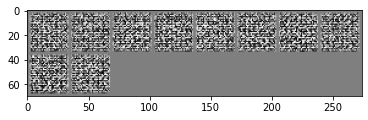

torch.Size([10, 1, 32, 32])

In [13]:
z = get_z(batch_size=10)
img_fake = gen(z).view((-1, 1, 32, 32))
imshow_grid(img_fake.cpu().detach())
img_fake.shape

  0%|          | 0/200 [00:00<?, ?it/s]

[0/200] loss_d : -0.0401, loss_g : -0.0481


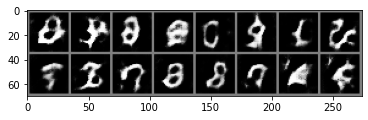

  5%|▌         | 10/200 [02:11<41:34, 13.13s/it]

[10/200] loss_d : -0.0305, loss_g : -0.0321


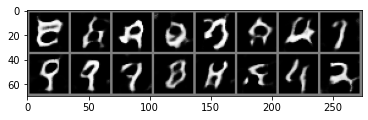

 10%|█         | 20/200 [04:24<39:21, 13.12s/it]

[20/200] loss_d : -0.0146, loss_g : -0.1237


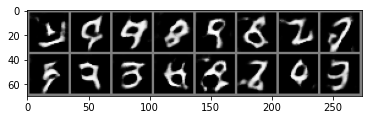

 15%|█▌        | 30/200 [06:35<37:15, 13.15s/it]

[30/200] loss_d : -0.0315, loss_g : -0.1360


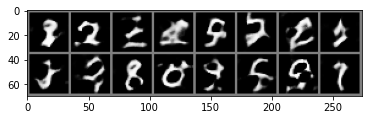

 20%|██        | 40/200 [08:47<35:04, 13.15s/it]

[40/200] loss_d : -0.0240, loss_g : -0.0476


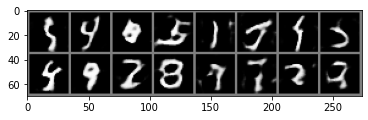

 25%|██▌       | 50/200 [10:59<32:51, 13.14s/it]

[50/200] loss_d : -0.0223, loss_g : -0.0454


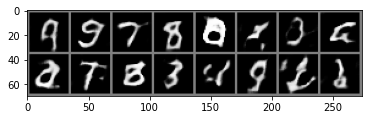

 30%|███       | 60/200 [13:09<30:37, 13.12s/it]

[60/200] loss_d : -0.0237, loss_g : -0.1363


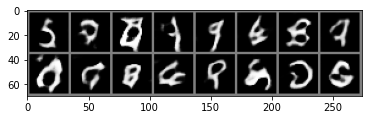

 35%|███▌      | 70/200 [15:21<28:48, 13.29s/it]

[70/200] loss_d : -0.0196, loss_g : -0.1708


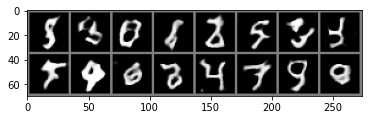

 40%|████      | 80/200 [17:34<26:39, 13.33s/it]

[80/200] loss_d : -0.0207, loss_g : -0.0380


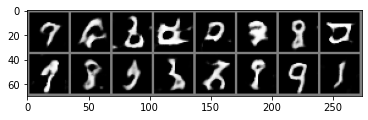

 45%|████▌     | 90/200 [19:47<24:09, 13.18s/it]

[90/200] loss_d : -0.0279, loss_g : -0.1582


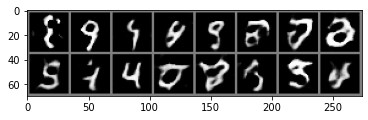

 50%|█████     | 100/200 [21:58<21:55, 13.16s/it]

[100/200] loss_d : -0.0232, loss_g : -0.0392


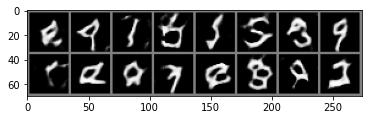

 55%|█████▌    | 110/200 [24:12<20:15, 13.51s/it]

[110/200] loss_d : -0.0105, loss_g : -0.1509


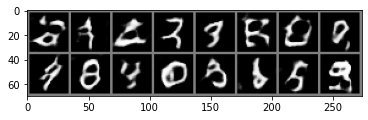

 60%|██████    | 120/200 [26:24<17:31, 13.14s/it]

[120/200] loss_d : -0.0096, loss_g : -0.1250


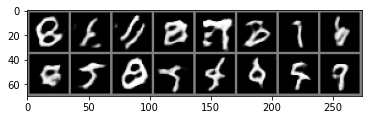

 65%|██████▌   | 130/200 [28:34<15:10, 13.00s/it]

[130/200] loss_d : -0.0259, loss_g : -0.0839


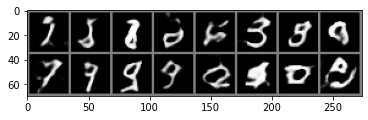

 70%|███████   | 140/200 [30:47<13:14, 13.24s/it]

[140/200] loss_d : -0.0269, loss_g : -0.0787


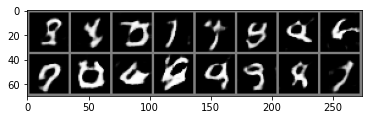

 75%|███████▌  | 150/200 [33:00<10:58, 13.17s/it]

[150/200] loss_d : -0.0198, loss_g : -0.0583


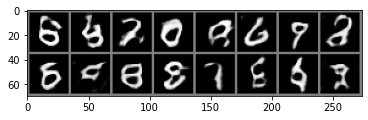

 80%|████████  | 160/200 [35:09<08:39, 13.00s/it]

[160/200] loss_d : -0.0142, loss_g : -0.1238


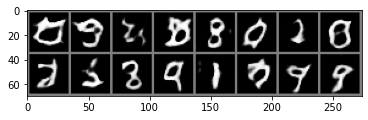

 85%|████████▌ | 170/200 [37:20<06:31, 13.05s/it]

[170/200] loss_d : -0.0295, loss_g : -0.0755


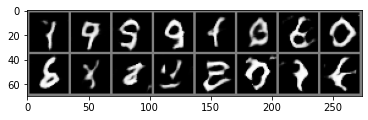

 90%|█████████ | 180/200 [39:33<04:23, 13.20s/it]

[180/200] loss_d : -0.0171, loss_g : -0.1572


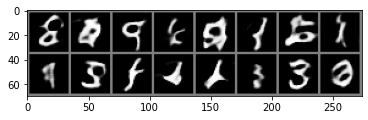

 95%|█████████▌| 190/200 [41:46<02:13, 13.37s/it]

[190/200] loss_d : -0.0223, loss_g : -0.1489


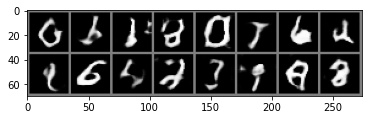

100%|██████████| 200/200 [43:57<00:00, 13.19s/it]


FileNotFoundError: [Errno 2] No such file or directory: './model/wGenerator.pth'

In [14]:
train(gen, critic, optim_G, optim_C, train_dataloader)

In [15]:
'''torch.save(gen, './model/wGenerator.pth')
torch.save(critic, './model/wCritic.pth')'''

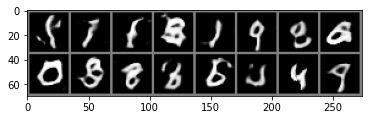

In [16]:
z = get_z(batch_size=16)
imgs = gen(z)
imshow_grid(imgs.cpu().detach())